## Medtext Pipeline

Assembling, parsing, crawling of all components to build the medtext databases. Further information can be found in the wiki: http://wiki.eonum.ch/doku.php?id=data:medicaltext




In [107]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import nltk

### define a new configuration
config_dict = {
    # databases
    "medical_books_pdf_folder": "/media/data/medical_books/medical_books_pdf",
    "medical_books_txt_folder": "/media/data/medical_books/test_out/",
    "wiki_dump_url": "https://dumps.wikimedia.org/dewiki/latest/dewiki-latest-pages-articles.xml.bz2",
    "wiki_dump": "/media/data/wiki_dumps/dewiki-latest-pages-articles.xml.bz2",
    "categories_file": "/media/data/wiki_dumps/categories",
    "categories_dump_file": "../wiki_dumps/dewiki-latest-category.sql",
    "wiki_all_texts": "/media/data/wiki_dumps/wiki_med_txts_2018",
    "wiki_medical_txt": "/media/data/wiki_dumps/wiki_med_txts_2018/positive",
    "wiki_non_medical_txt": "/media/data/wiki_dumps/wiki_med_txts_2018/negative",
    "crawler_output_html": "/media/data/medtextcollector/data/output/crawler/raw",
    "crawler_output_txt": "/media/data/medtextcollector/data/output/crawler/pages",
    
    # data for labeling
    "sentences_manual_labeling_file": "/media/data/sentence_classification/data/sentences_for_manual_labeling.csv",
    
    # models
    "medtext_classifier_config": "/media/data/configuration-medtext-notebook-pipeline-crawler.json",
    "medtext_classifier_folder": "/media/data/medtext_classifier_and_crawler",
    "embedding_model": "",
    
    # chose tokenizer. possible values: "nst" and "sgt"
    ## NonStemmingTokenizer: 'nst'
    # - no stemming, only remove punctuation marks
    # - lowercase letters

    ## SimpleGermanTokenizer: 'sgt'
    # - remove punctuation marks
    # - stemming
    # - lowercase letters
    "tokenizer": "nst",
    
    # where to store the configuration file
    "config_path": "/media/data/configuration-medtext-notebook.json"
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [104]:
# load sentence detector and tokenizer

import nltk
from notebooks.tokenizer import get_tokenizer
from data_analysis_toolkit import extract_sentences

sentence_detector = nltk.data.load('tokenizers/punkt/german.pickle')
tokenizer = get_tokenizer(config_dict['tokenizer'])

print(extract_sentences("Dies ist ein Beispielsatz! Und hier noch einmal.\nNeuer Absatz: Aber hallo.. Du"
                                 + "\nUnd ein Beispiel z.B. oder z.Bsp: Ein Beispiel. " +
                        "J. P. Klein (1), S. Moritz (2), T. Berger (3)", sentence_detector))

tokenizer.tokenize("Dies ist ein Beispielastz! Komm wir machen eine Überraschung und stemmen diesen Satz.\n p 987*/-_à!è")

['Dies ist ein Beispielsatz!', 'Und hier noch einmal.', 'Neuer Absatz: Aber hallo.. Du Und ein Beispiel z.B. oder z.Bsp: Ein Beispiel.', 'Klein (1), S. Moritz (2), T. Berger (3)']


['dies',
 'ist',
 'ein',
 'beispielastz',
 'komm',
 'wir',
 'machen',
 'eine',
 'überraschung',
 'und',
 'stemmen',
 'diesen',
 'satz',
 'p',
 '987',
 'à',
 'è']

Raw data bases


database,files
/media/data/medical_books/medical_books_pdf,53869
/media/data/medtextcollector/data/output/crawler/raw,8009
/media/data/wiki_dumps/wiki_med_txts_2018/negative,9377
/media/data/wiki_dumps/wiki_med_txts_2018,18754


Cleaned data bases


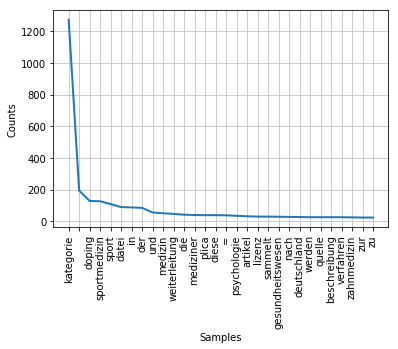

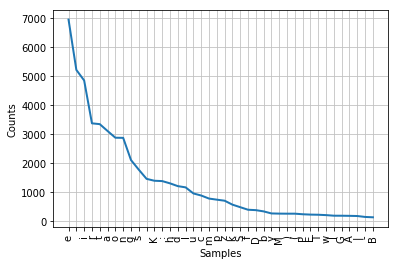

['/media/data/wiki_dumps/wiki_med_txts_2018/positive', 9377, 506, 595, 5606, 1488, 111, 0.9254032258064516]


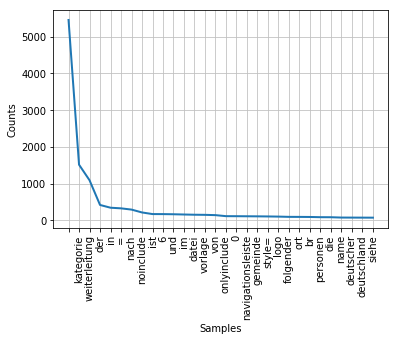

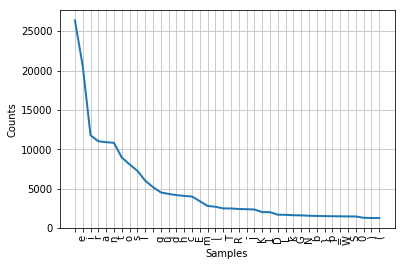

['/media/data/wiki_dumps/wiki_med_txts_2018/negative', 9377, 2080, 2351, 28122, 7331, 439, 0.9401173100531988]


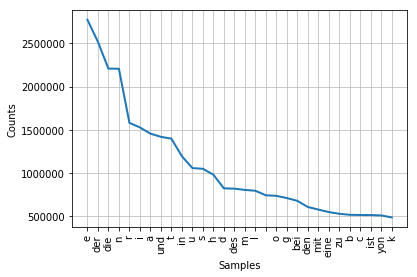

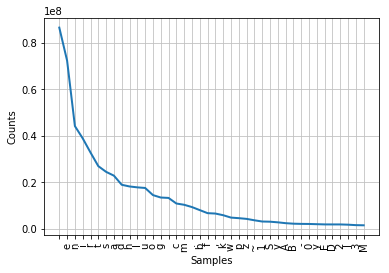

['/media/data/medical_books/test_out/', 53798, 23582, 4800536, 92941886, 3132537, 379598, 0.8788209045894749]


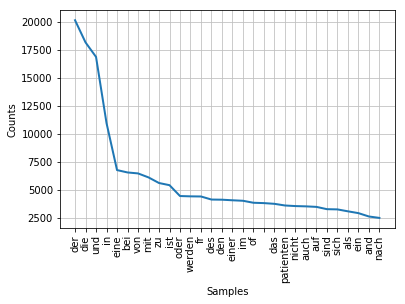

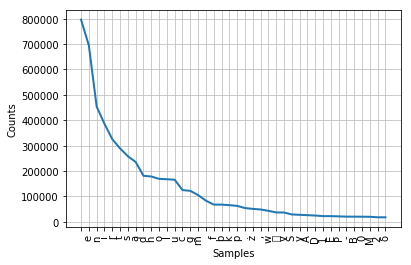

['/media/data/medtextcollector/data/output/crawler/pages', 29666, 314, 38033, 697038, 74919, 11570, 0.8455665452021517]


database,files,documents,sentences,tokens,vocabulary,vocabulary freq > 5,long tail ratio
/media/data/wiki_dumps/wiki_med_txts_2018/positive,9'377,506,595,5'606,1'488,111,0.9254032258064516
/media/data/wiki_dumps/wiki_med_txts_2018/negative,9'377,2'080,2'351,28'122,7'331,439,0.9401173100531988
/media/data/medical_books/test_out/,53'798,23'582,4'800'536,92'941'886,3'132'537,379'598,0.8788209045894749
/media/data/medtextcollector/data/output/crawler/pages,29'666,314,38'033,697'038,74'919,11'570,0.8455665452021517


Union vocabulary: 3'161'835
Intersection vocabulary: 374


In [122]:
# get number of files, sentences, tokens, vocabulary and character histograms in each database. 
# This cell takes quite a while to execute!
from data_analysis_toolkit import get_files_from_folder, load_documents

databases_raw = [config["medical_books_pdf_folder"], config["crawler_output_html"],
                config["wiki_non_medical_txt"], config['wiki_all_texts']]
databases_cleaned = [config["wiki_medical_txt"], config["wiki_non_medical_txt"],
                     config['medical_books_txt_folder'], config['crawler_output_txt']]

from IPython.display import HTML, display
import tabulate
import re
table = [["database", "files"]]

def swiss_number(number):
    return "{:,}".format(number).replace(',',"'")

print("Raw data bases")
for db in  databases_raw:
    table.append([db, len(get_files_from_folder(db))])
display(HTML(tabulate.tabulate(table, tablefmt='html')))

print("Cleaned data bases")
table = [["database", "files", "documents", "sentences", "tokens", "vocabulary",
          "vocabulary freq > 5", "long tail ratio"]]
vocs = []
docs = []
umlaute = re.compile(r'[öäü]')
for db in  databases_cleaned:
    files = get_files_from_folder(db)
    documents, load_errors = load_documents(files)
    
    documents = [doc for doc in documents if umlaute.search(doc) != None]
    sentences = []
    tokens = []
    docs.append(documents)
    fdc = nltk.FreqDist()
    fdc_tokens = nltk.FreqDist()
    for document in documents:
        fdc.update(document)
        sentences.extend(extract_sentences(document, sentence_detector))
    for sentence in sentences:
        tokens.extend(tokenizer.tokenize(sentence))
        # disable this if not enough time!
        #for token in tokens:
        #    fdc_tokens.update(token)
    voc = set(tokens)
    vocs.append(voc)
    
    # word frequencies
    fd = nltk.FreqDist(tokens)
    # print(fd.most_common(30))
    fd.plot(30,cumulative=False)   
    
    # character frequencies
    # print(fdc.most_common(40))
    fdc.plot(40,cumulative=False)
    
    #fdc_tokens.plot(40,cumulative=False)
    
    cropped_vocab_size = len([e for e in fd.items() if fd.get(e[0]) > 5])
    vocab_size = len(voc)
    long_tail_ratio = (vocab_size - cropped_vocab_size) / vocab_size
    
    print([db, len(files), len(documents), len(sentences), len(tokens), vocab_size, 
           cropped_vocab_size, long_tail_ratio])
    table.append([db, swiss_number(len(files)), swiss_number(len(documents)), 
                  swiss_number(len(sentences)), swiss_number(len(tokens)), 
                  swiss_number(vocab_size), swiss_number(cropped_vocab_size),
                  swiss_number(long_tail_ratio)])  
    
    
display(HTML(tabulate.tabulate(table, tablefmt='html')))

voc_union = vocs[0]
voc_intersection = vocs[0]
for voc in vocs:
    voc_union = voc_union.union(voc)
    voc_intersection = voc_intersection.intersection(voc)

print("Union vocabulary: " + swiss_number(len(voc_union)))
print("Intersection vocabulary: " + swiss_number(len(voc_intersection)))

    

In [123]:
# inspect and analyze sample documents
from random import randint
for documents in docs:
    document = documents[randint(0, len(documents))]
    print("\n== Document ==")
    print(document)
    
    print("== Sentences ==")
    for sentence in extract_sentences(document, sentence_detector)[:4]:
        print(sentence)
        
    print("== Tokens ==")
    for sentence in extract_sentences(document, sentence_detector)[:4]:
        print(tokenizer.tokenize(sentence))
    


== Document ==
Die  Registry of Toxic Effects of Chemical Substances  ( RTECS ) ist eine  Datenbank   Toxikologie|toxikologischer  Informationen. Die Datenbank wurde bis Januar 2001 vom  Vereinigte Staaten|US-amerikanischen  National Institute for Occupational Safety and Health (NIOSH) betrieben und wird nun vom Unternehmen  Elsevier  MDL kostenpflichtig weiterbetrieben.

  Siehe auch  
*  TOXicology Data NETwork  (TOXNET)
== Sentences ==
Die  Registry of Toxic Effects of Chemical Substances  ( RTECS ) ist eine  Datenbank   Toxikologie|toxikologischer  Informationen.
Die Datenbank wurde bis Januar 2001 vom  Vereinigte Staaten|US-amerikanischen  National Institute for Occupational Safety and Health (NIOSH) betrieben und wird nun vom Unternehmen  Elsevier  MDL kostenpflichtig weiterbetrieben.
Siehe auch   *  TOXicology Data NETwork  (TOXNET)
== Tokens ==
['die', 'registry', 'of', 'toxic', 'effects', 'of', 'chemical', 'substances', 'rtecs', 'ist', 'eine', 'datenbank', 'toxikologie', 'tox

In [117]:
# sentence extraction for manual sentence labeling: proper German sentence, non German, non sentence

num_sentences = 0
with open(config['sentences_manual_labeling_file'], 'w') as f:
    while True:
        # pick DB
        documents = docs[randint(0, len(docs)-1)]
        
        # pick document
        doc = documents[randint(0, len(documents)-1)]
        
        num_sentences_in_doc = 0
        for sentence in extract_sentences(doc, sentence_detector):
            sentence = sentence.replace(';', '.')
            f.write(sentence + ";" + str(tokenizer.tokenize(sentence)) + "\n")
            num_sentences += 1
            num_sentences_in_doc += 1
            if num_sentences_in_doc > 1:
                break
        if num_sentences > 2000:
            break
    

In [67]:
# download wiki dump. Takes ~ 40min
import urllib.request

from tqdm import tqdm
#from tqdm import tnrange, tqdm_notebook

class TqdmUpTo(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize

with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=config["wiki_dump_url"].split('/')[-1]) as t:  # all optional kwargs
    urllib.request.urlretrieve(config["wiki_dump_url"], config["wiki_dump"], reporthook=t.update_to, data=None)

dewiki-latest-pages-articles.xml.bz2: 4.88GB [39:21, 2.06MB/s]                               


In [26]:
# extract wiki dump. Takes ~ 15min

from subprocess import call
call(["bzip2", "-dk", config["wiki_dump"]])

0

In [34]:
# create categories file
call(["ruby", "scripts/scan_categories.rb", config["categories_dump_file"], config['categories_file']])

0

In [39]:
# extract medical and non medical articles from wiki dump
# convert XML to TXT: medical and non-medical (negative) samples

# execute this on titan (execution takes ~ 1h):
print("ruby scripts/wiki_xml_extractor.rb " + config["wiki_dump"].replace(".bz2", "") + " "
      + config['wiki_all_texts'] + " " + config['categories_file']) 

ruby scripts/wiki_xml_extractor.rb /media/data/wiki_dumps/dewiki-latest-pages-articles.xml /media/data/wiki_dumps/wiki_med_txts_2018 /media/data/wiki_dumps/categories


In [95]:
# train medtext classifier
import time

config_pipeline_crawler = {
    "base-folder": config['medtext_classifier_folder'],
    "input-folder": config['wiki_all_texts'],
    "classifier-name": "medtext-pipeline-" + time.strftime("%d-%m-%Y"),
    "crawler-root-url": "http://www.netdoktor.de/krankheiten/",
    "boilerplate-removal": "readability",
    "max_urls": -1,
    "testset-ratio": 0.1,
    "threshold": 0.8,
    "max-visits-per-tld": -1,
    "max-dataset-size": -1,
    "doc-min-tokens": 10,
    "urldefrag": True,
    "excluded-urls": [],
    "excluded-keywords-url": ["wikipedia"],
    "invert-p": False,
    "mandatory-keywords-url": [],
    "store-raw": True
}

config_filename = config['medtext_classifier_config']

with open(config_filename, 'w+') as f:
    json.dump(config_pipeline_crawler, f, indent=4)

# run on titan:
print("python medtext_classification_pipeline.py -c " + config_filename)

python medtext_classification_pipeline.py -c /media/data/configuration-medtext-notebook-pipeline-crawler.json


In [93]:
# start crawler

# run on titan:
print("python crawler.py -c " + config_filename)

python crawler.py -c /media/data/configuration-medtext-notebook-pipeline-crawler.json


In [94]:
# extract TXT from PDFs

# run ont titan:
print("python pdfs_to_documents.py -i " + config['medical_books_pdf_folder'] +
      " -o " + config['medical_books_txt_folder'])

python pdfs_to_documents.py -i /media/data/medical_books/medical_books_pdf -o /media/data/medical_books/medical_books_plaintxt/


In [ ]:
# train embedding / start medword

# TODO